<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_11_3_NEAT_GYMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/CodeReclaimers/neat-python.git -q

In [ ]:
!apt-get install -y xvfb x11-utils
# install required python dependencies
!pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            mediapy \
            piglet -q

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 2s (650 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155639 files

In [ ]:
!echo $DISPLAY

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [ ]:
import gym.wrappers
import matplotlib.pyplot as plt
import multiprocessing
import os
import pickle
import numpy as np
import mediapy 
import random

import neat

NUM_CORES = 8

action space: Box(-2.0, 2.0, (1,), float32)
observation space: Box(-8.0, 8.0, (3,), float32)


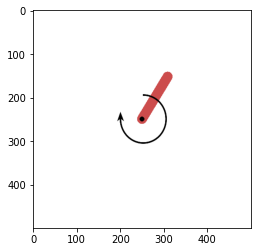

In [ ]:
#@title Setup Environment { run: "auto" }
ENVIRONMENT = "Pendulum-v0" #@param ["CartPole-v1", "Acrobot-v1", "Pendulum-v0", "CubeCrash-v0", "MountainCar-v0", "LunarLander-v2"]

env = gym.make(ENVIRONMENT)

state = env.reset()
plt.imshow(env.render(mode='rgb_array'))

print("action space: {0!r}".format(env.action_space))
print("observation space: {0!r}".format(env.observation_space))

In [ ]:
#@title Siumlate Environment Run { run: "auto" }
ENVIRONMENT = "CartPole-v1" #@param ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "LunarLander-v2"]
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}
SIMULATION_ITERATIONS = 200 #@param {type:"slider", min:50, max:200, step:1}

env = gym.make(ENVIRONMENT)

fitnesses = []
frames = []

for run in range(SIMULATION_RUNS):  
  state = env.reset()
  fitness = 0
  for i in range(SIMULATION_ITERATIONS):
    action = env.action_space.sample()
    state, reward, done, info = env.step(np.argmax(action))  
    frames.append(env.render(mode='rgb_array'))  
    fitness += reward       
    if done: 
      fitnesses.append(fitness) 
      break 

mediapy.show_video(frames, fps=30)
print(fitnesses)

[8.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 9.0]


In [ ]:
print(env.observation_space.shape[0])

4


In [ ]:
inputs = env.observation_space.shape[0]
outputs = env.action_space.n

config = f'''
# NEAT configuration for the bit-sequence memory experiment.

# The `NEAT` section specifies parameters particular to the NEAT algorithm
# or the experiment itself.  This is the only required section.
[NEAT]
fitness_criterion     = max
fitness_threshold     = 175.0
pop_size              = 250
reset_on_extinction   = 0

[DefaultGenome]
num_inputs              = {inputs}
num_hidden              = 1
num_outputs             = {outputs}
initial_connection      = partial_direct 0.5
feed_forward            = True
compatibility_disjoint_coefficient    = 1.0
compatibility_weight_coefficient      = 0.6
conn_add_prob           = 0.2
conn_delete_prob        = 0.2
node_add_prob           = 0.2
node_delete_prob        = 0.2
activation_default      = sigmoid
activation_options      = sigmoid
activation_mutate_rate  = 0.0
aggregation_default     = sum
aggregation_options     = sum
aggregation_mutate_rate = 0.0
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_replace_rate       = 0.1
bias_mutate_rate        = 0.7
bias_mutate_power       = 0.5
bias_max_value          = 30.0
bias_min_value          = -30.0
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_replace_rate   = 0.0
response_mutate_rate    = 0.0
response_mutate_power   = 0.0
response_max_value      = 30.0
response_min_value      = -30.0

weight_max_value        = 30
weight_min_value        = -30
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1
weight_mutate_power     = 0.5
enabled_default         = True
enabled_mutate_rate     = 0.01

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation  = 20

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2
'''
print(config, file=open('config', 'w'))

In [ ]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config')

print(config.genome_type, config.genome_config,config.pop_size)

<class 'neat.genome.DefaultGenome'> <neat.genome.DefaultGenomeConfig object at 0x7f9d1b274910> 250


In [ ]:
env = gym.make(ENVIRONMENT)
state = env.reset()
print(state)

[ 0.01404114 -0.03348728  0.02242439  0.02621674]


In [ ]:
key = "fred"
fred = config.genome_type(key)
fred.configure_new(config.genome_config)

net = neat.nn.FeedForwardNetwork.create(fred, config)
action = net.activate(state)
print(action)

[0.38141132752580453, 0.43957152806458866]


In [ ]:
env.reset()
state, reward, done, info = env.step(np.argmax(action))
print(state, reward, done, info)

[ 0.00670061  0.15336912  0.00928008 -0.30874356] 1.0 False {}


In [ ]:
#@title Simulation Options { run: "auto" }
SIMULATION_ITERATIONS = 200
SIMULATION_RUNS = 10 #@param {type:"slider", min:1, max:10, step:1}

frames = []
fitnesses = []
for run in range(SIMULATION_RUNS):  
  state = env.reset()
  fitness = 0
  for i in range(SIMULATION_ITERATIONS):
    action = net.activate(state)
    state, reward, done, info = env.step(np.argmax(action))  
    frames.append(env.render(mode='rgb_array'))  
    fitness += reward       
    if done: 
      fitnesses.append(fitness) 
      break 

print(fitnesses)
mediapy.show_video(frames, fps=30)

[9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 8.0, 10.0]


In [ ]:
def eval_genome(genome, config):
  net = neat.nn.FeedForwardNetwork.create(genome, config)
  fitnesses = []
  for run in range(SIMULATION_RUNS):  
    state = env.reset()
    fitness = 0
    for i in range(SIMULATION_ITERATIONS):
      action = net.activate(state)
      state, reward, done, info = env.step(np.argmax(action))  
      fitness += reward       
      if done: 
        fitnesses.append(fitness) 
        break 
  return 0.0 if len(fitnesses) < 1 else min(fitnesses)

def eval_genomes(genomes, config):
  for genome_id, genome in genomes:    
    genome.fitness = eval_genome(genome, config)

print(eval_genome(fred, config))

8.0


In [ ]:
pop = neat.Population(config)
stats = neat.StatisticsReporter()
pop.add_reporter(stats)
pop.add_reporter(neat.StdOutReporter(True))

pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
winner = pop.run(pe.evaluate)
#winner = pop.run(eval_genomes)


 ****** Running generation 0 ****** 

Population's average fitness: 12.99200 stdev: 13.85005
Best fitness: 149.00000 - size: (3, 7) - species 2 - id 140
Average adjusted fitness: 0.023
Mean genetic distance 2.430, standard deviation 0.582
Population of 251 members in 6 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0   116     30.000    0.012     0
     2    0     2    149.000    0.048     0
     3    0    63     78.000    0.043     0
     4    0    32     15.000    0.007     0
     5    0     1      8.000    0.000     0
     6    0    37     40.000    0.025     0
Total extinctions: 0
Generation time: 2.487 sec

 ****** Running generation 1 ****** 

Population's average fitness: 21.36255 stdev: 23.92685
Best fitness: 181.00000 - size: (3, 8) - species 3 - id 342

Best individual in generation 1 meets fitness threshold - complexity: (3, 8)


In [ ]:
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
state = env.reset()
frames = []
for _ in range(SIMULATION_RUNS):
  for i in range(SIMULATION_ITERATIONS):
    action = winner_net.activate(state)
    state, reward, done, info = env.step(np.argmax(action)) 
    img = env.render(mode='rgb_array')
    frames.append(img)
    if done: break 

mediapy.show_video(frames, fps=30)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
